In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from QAckis.motionanalysis.parse_msnrbf_2 import parse_msnrbf_2
from QAckis.motionanalysis.distill_msrbf import distill_msnrbf
from QAckis.motionanalysis.parse_msnrbf import MSNRBF
import json
import glob, os



3800849357.6784115
3800849357.884429
3800849358.091414
3800849361.4853315
3800849361.6913466
3800849361.8983307
3800849362.104341
3800849362.3113403
3800849362.517338
3800849362.7243323
3800849357.6784115
3800849361.4853315
3800849362.104341
3800849362.7243323
3800849363.3443236
3800849363.9633346
3800849364.5833273
3800849365.2033186
3800849365.822354
3800849366.4423485


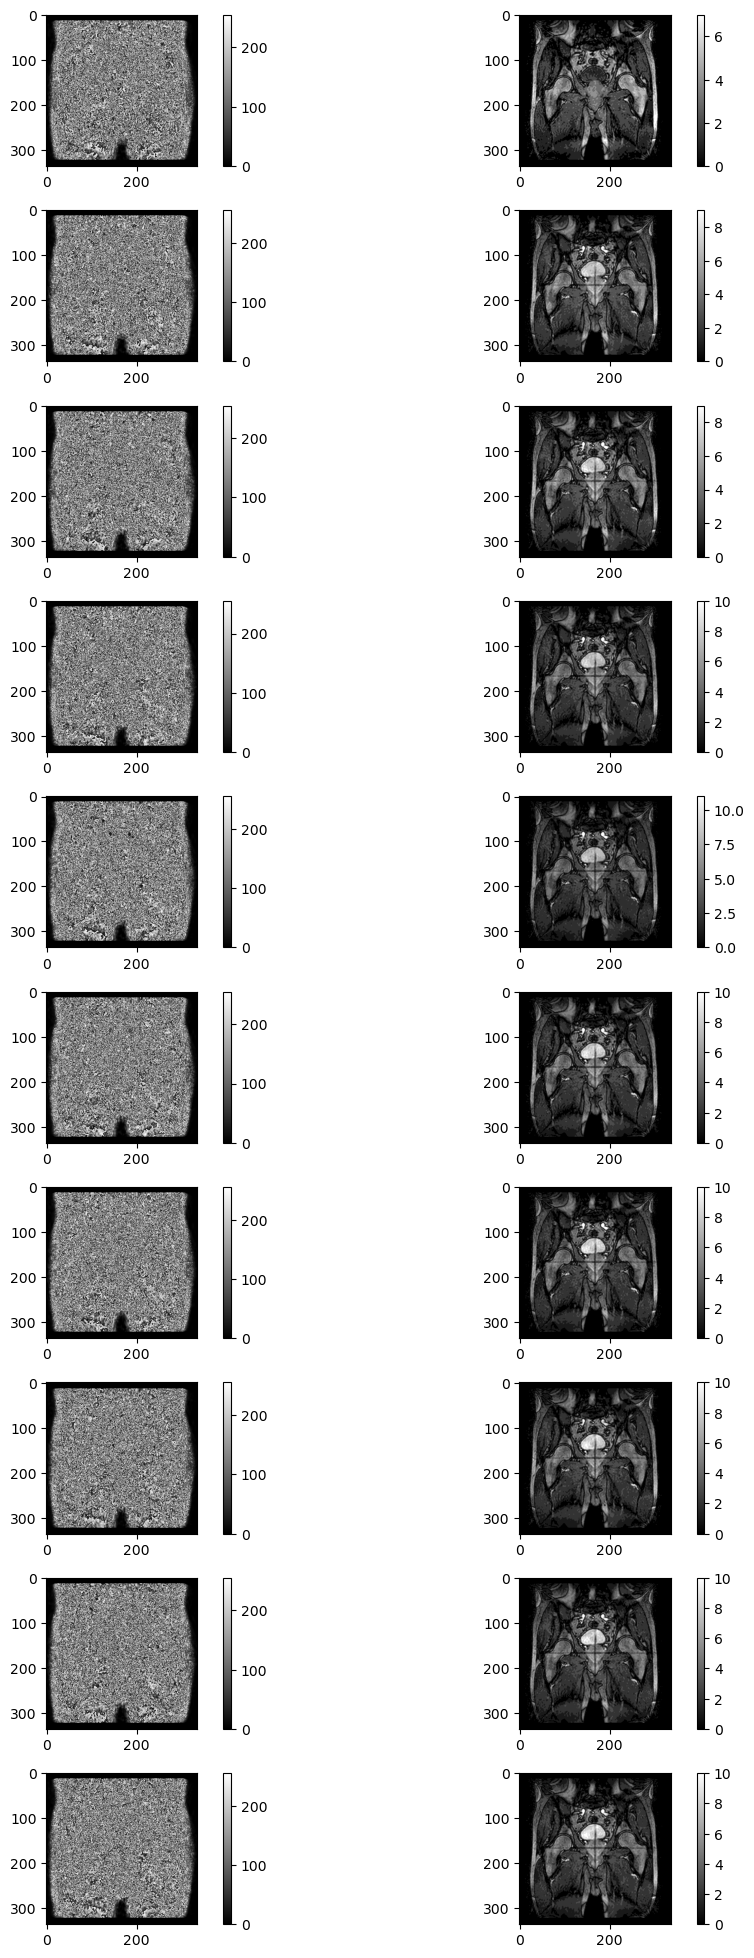

In [13]:
filename = '/home/david/source/QAckis/QAckis/TestData/cine/example.bin'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/cines'
filenames = glob.glob(os.path.join(path, '*.bin'))

f, axes = plt.subplots(10, 2, figsize=(30/2.54, 50/2.54))

#
# Read all images
#
bin_data = [ ]

for i, filename in enumerate(filenames[:100]):
    nrbf = MSNRBF(filename)
    distilled = distill_msnrbf(nrbf._records)
    bin_data.append(distilled)
    #data = np.array(distilled['TwoDSlicedata']['Data']).reshape([336, 336, 2])
    #images.append(data[1])

#
# Sort in time
# 
t_sorted_bin_data = sorted(bin_data, key=lambda data: data['TwoDSlicedata']['Elapsed100NanosecondInterval'])
for i in range(10):
    print(t_sorted_bin_data[i]['TwoDSlicedata']['Elapsed100NanosecondInterval'] * (100*1e-9))

#
# Sort direction
# distilled['TwoDSlicedata']['Orientation']
def direction_cosines(record):
    row_dir = record['TwoDSlicedata']['Orientation']['RowDirectionCosines']
    col_dir = record['TwoDSlicedata']['Orientation']['ColumnDirectionCosines']
    return np.array([row_dir['X'], row_dir['Y'], row_dir['Z'],col_dir['X'], col_dir['Y'], col_dir['Z']])


chosen_dir_cosines = np.array([1, 0, 0, 0, 0, -1])
#chosen_dir_cosines = np.array([0, 1, 0, 0, 0, -1])
#chosen_dir_cosines = np.array([1, 0, 0, 0, 1, 0])

t_sorted_bin_data_direction = list(filter(lambda data: np.allclose(chosen_dir_cosines, direction_cosines(data)), t_sorted_bin_data))
for i in range(10):
    print(t_sorted_bin_data_direction[i]['TwoDSlicedata']['Elapsed100NanosecondInterval'] * (100*1e-9))

#print(distilled['TwoDSlicedata']['Elapsed100NanosecondInterval'] * (100*1e-9))

for i in range(10):
    distilled = t_sorted_bin_data_direction[i] 
    #filename = path + '/cine' + str(i) + '.bin'
    #nrbf = MSNRBF(filename)
    #distilled = distill_msnrbf(nrbf._records)
    images = np.array(distilled['TwoDSlicedata']['Data']).reshape([336, 336, 2])
    im0 = axes[i][0].imshow(images[:,:,0], cmap='gray')
    im1 = axes[i][1].imshow(images[:,:,1], cmap='gray')
    f.colorbar(im0, ax=axes[i][0], fraction=0.046, pad=0.04)
    f.colorbar(im1, ax=axes[i][1], fraction=0.046, pad=0.04)

f.tight_layout()




In [21]:
#t_sorted_bin_data[0]['TimingInfo'] 
mtx = np.array(t_sorted_bin_data[0]['MMEMonitoringResult']['Data']).reshape([336, 336, 2])
plt.imshow(mtx[1])



KeyError: 'Data'

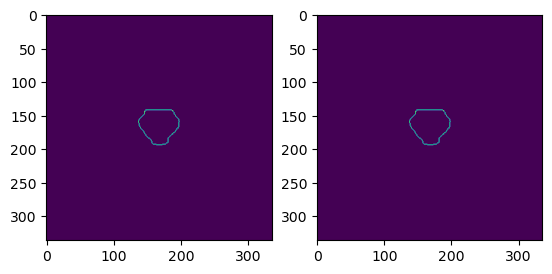

In [44]:
mtx = np.array(t_sorted_bin_data[0]['MMEMonitoringResult']['ResultStructures']['items'][0]['m_Item2']['Data']).reshape([336, 336, 2])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mtx[:,:,0])
ax2.imshow(mtx[:,:,1])